<ipython-input-9-b651843e3603>:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_0.75_224 (Functional)    │ (None, 1, 1, 1280)          │       1,382,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,712,570 (6.53 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 1,382,064 (5.27 MB)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.2563 - loss: 2.0406 - val_accuracy: 0.3527 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.3405 - loss: 1.8382 - val_accuracy: 0.3534 - val_loss: 1.7893 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.3455 - loss: 1.8141 - val_accuracy: 0.3665 - val_loss: 1.7584 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.3568 - loss: 1.7841 - val_accuracy: 0.3736 - val_loss: 1.7495 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.3603 - loss: 1.7792 - val_accuracy: 0.3704 - val_loss: 1.7358 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.3654 - loss: 1.7666 - val_accuracy: 0.3782 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.3663 - l

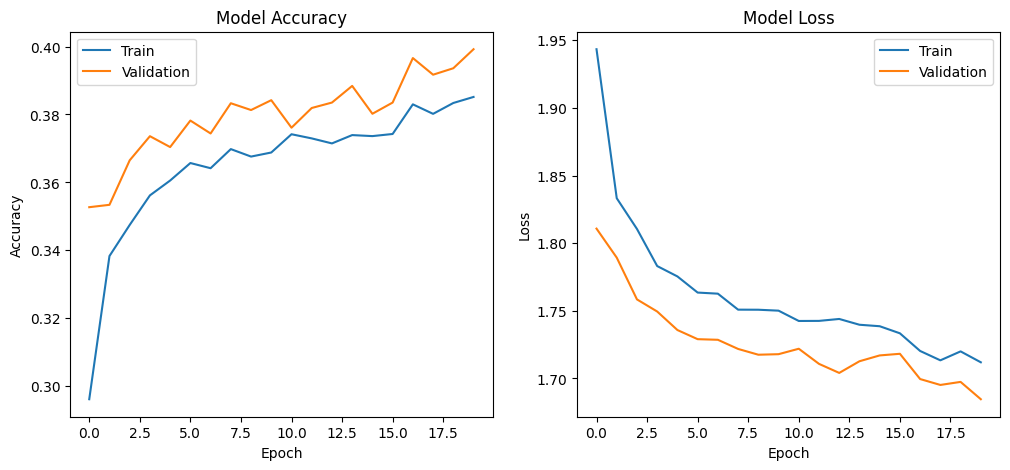

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

## 1. Load and Prepare Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# MobileNetV2 specific preprocessing (scale to [-1, 1])
x_train = x_train.astype('float32') / 127.5 - 1.0
x_test = x_test.astype('float32') / 127.5 - 1.0

## 2. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=64,
    subset='training'
)

val_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=64,
    subset='validation'
)

## 3. Build Model
def create_model():
    # Load MobileNetV2 base
    base_model = MobileNetV2(
        input_shape=(32, 32, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.75  # Slightly smaller than default
    )
    base_model.trainable = False  # Freeze initially

    # Create new model head
    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

model, base_model = create_model()
model.summary()

## 4. Train Initial Model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

## 5. Fine-Tuning
def fine_tune_model(model, base_model):
    # Unfreeze top layers
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = fine_tune_model(model, base_model)

# Train with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=10,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

## 6. Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

## 7. Visualization
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

## 1. Load and Properly Preprocess Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# CORRECT MobileNetV2 preprocessing
def preprocess_mobilenet(images):
    images = images.astype('float32')
    images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
    return images

x_train = preprocess_mobilenet(x_train)
x_test = preprocess_mobilenet(x_test)

## 2. Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced from 15 for small images
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],  # Small brightness adjustment
    validation_split=0.2
)

# Use smaller batch size for better gradient updates
batch_size = 32

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    subset='training'
)

val_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    subset='validation'
)

## 3. Build Optimized Model
def build_optimized_model():
    # Use smaller alpha for CIFAR-10's 32x32 images
    base_model = MobileNetV2(
        input_shape=(32, 32, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.5  # Smaller model works better for small images
    )

    # Freeze base model initially
    base_model.trainable = False

    # Create new model head with regularization
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Use lower initial learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

model, base_model = build_optimized_model()
model.summary()

## 4. First Training Phase (Frozen Base)
print("\nTraining Phase 1: Frozen Base Model")
early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

## 5. Second Phase (Partial Fine-Tuning)
print("\nTraining Phase 2: Partial Fine-Tuning")
# Unfreeze top layers only
base_model.trainable = True
for layer in base_model.layers[:120]:  # Freeze first 120 layers
    layer.trainable = False

# Recompile with even lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=15,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

## 6. Final Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

## 7. Plot Results
def plot_combined_history(history1, history2):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Phase 1 Train')
    plt.plot(history1.history['val_accuracy'], '--', label='Phase 1 Val')
    plt.plot([len(history1.history['accuracy']) + i for i in range(len(history2.history['accuracy']))],
             history2.history['accuracy'], label='Phase 2 Train')
    plt.plot([len(history1.history['accuracy']) + i for i in range(len(history2.history['accuracy']))],
             history2.history['val_accuracy'], '--', label='Phase 2 Val')
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Phase 1 Train')
    plt.plot(history1.history['val_loss'], '--', label='Phase 1 Val')
    plt.plot([len(history1.history['loss']) + i for i in range(len(history2.history['loss']))],
             history2.history['loss'], label='Phase 2 Train')
    plt.plot([len(history1.history['loss']) + i for i in range(len(history2.history['loss']))],
             history2.history['val_loss'], '--', label='Phase 2 Val')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_combined_history(history, history_fine)

<ipython-input-11-fd6b19c3c8d5>:55: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_0.50_224 (Functional)    │ (None, 1, 1, 1280)          │         706,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 877,114 (3.35 MB)

 Trainable params: 168,074 (656.54 KB)

 Non-trainable params: 709,040 (2.70 MB)


Training Phase 1: Frozen Base Model
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 46ms/step - accuracy: 0.1960 - loss: 2.8410 - val_accuracy: 0.2923 - val_loss: 2.2324 - learning_rate: 5.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.2341 - loss: 2.2663 - val_accuracy: 0.3017 - val_loss: 2.1321 - learning_rate: 5.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.2430 - loss: 2.1896 - val_accuracy: 0.3082 - val_loss: 2.0821 - learning_rate: 5.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.2448 - loss: 2.1569 - val_accuracy: 0.3030 - val_loss: 2.0461 - learning_rate: 5.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.2508 - loss: 2.1331 - val_accuracy: 0.3044 - val_loss: 2.0276 - learning_rate: 5.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.2460 - loss: 2.1225 - val_accuracy: 0.2966 - val_loss: 2.0300 - learning_rate: 5.0000e-04
Epo

due to internet connectivity, the training of the model was interrupted in between and was not going forward. But, the earlier trained model is coded above this model.